In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway

###  LLM Personality Profiles Comparison (Radar Chart)

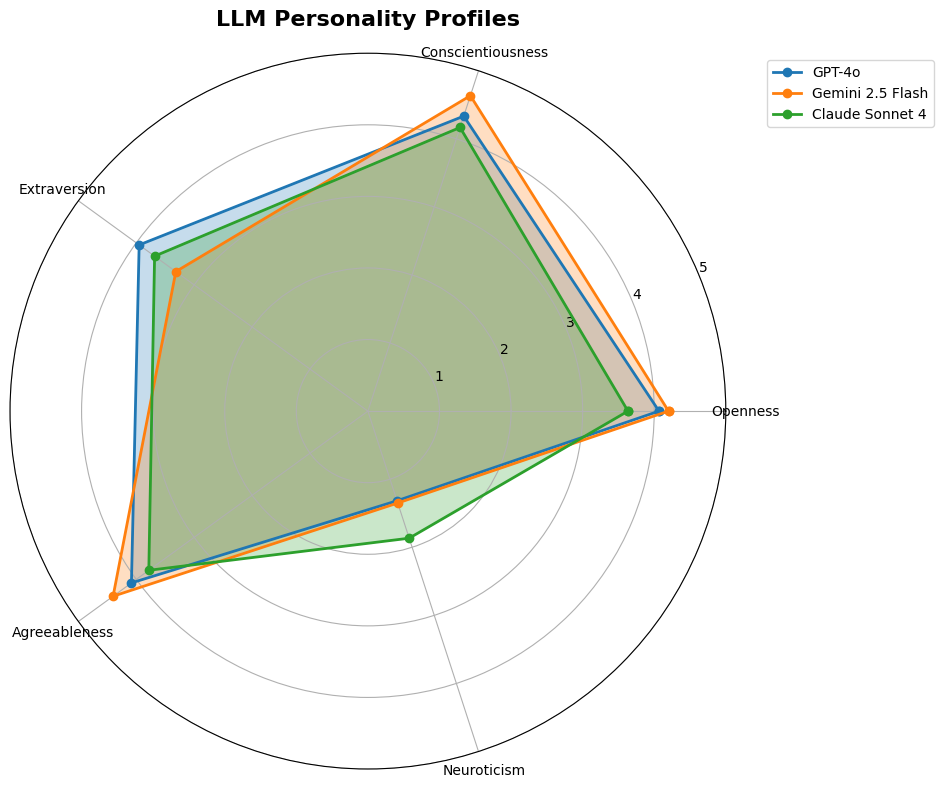

LLM Personality Means:
                  openness  conscientiousness  extraversion  agreeableness  \
llm                                                                          
claude sonnet 4       3.63               4.17          3.68           3.78   
gemini 2.5 flash      4.20               4.63          3.32           4.40   
gpt 4-o               4.07               4.33          3.95           4.08   

                  neuroticism  
llm                            
claude sonnet 4          1.87  
gemini 2.5 flash         1.35  
gpt 4-o                  1.32  


In [3]:
# Load the dataset
df = pd.read_csv('results_dataset.csv')

# Calculate personality trait means by LLM
personality_traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
llm_means = df.groupby('llm')[personality_traits].mean()

# Prepare data for radar chart
categories = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
gpt4o = llm_means.loc['gpt 4-o'].values.tolist()
gemini = llm_means.loc['gemini 2.5 flash'].values.tolist()
claude = llm_means.loc['claude sonnet 4'].values.tolist()

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

# Angles for each axis
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Add data points
for name, values, color in [('GPT-4o', gpt4o, '#1f77b4'), 
                           ('Gemini 2.5 Flash', gemini, '#ff7f0e'), 
                           ('Claude Sonnet 4', claude, '#2ca02c')]:
    values += values[:1]  # Complete the circle
    ax.plot(angles, values, 'o-', linewidth=2, label=name, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

# Customize chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 5)
ax.set_title('LLM Personality Profiles', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()

# Print the actual values for verification
print("LLM Personality Means:")
print(llm_means.round(2))

#### Cohen's d Analysis for Tone Effects

In [4]:
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size between two groups"""
    n1, n2 = len(group1), len(group2)
    s1, s2 = group1.std(ddof=1), group2.std(ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (group1.mean() - group2.mean()) / pooled_std
    return d

def interpret_cohens_d(d):
    """Interpret Cohen's d magnitude"""
    abs_d = abs(d)
    if abs_d < 0.2:
        return "Negligible"
    elif abs_d < 0.5:
        return "Small"
    elif abs_d < 0.8:
        return "Medium"
    elif abs_d < 1.2:
        return "Large"
    else:
        return "Very Large"

# Define personality traits
trait_display_names = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']

print("=== COHEN'S d EFFECT SIZES: TONE EFFECTS ===\n")

# Calculate Cohen's d for different tone comparisons
tone_comparisons = [
    ('friendly', 'critical', 'Friendly vs Critical'),
    ('friendly', 'formal', 'Friendly vs Formal'),
    ('friendly', 'passive-aggressive', 'Friendly vs Passive-Aggressive')
]

all_effect_sizes = []

for comparison_name, (tone1, tone2, display_name) in zip(['friendly_vs_critical', 'friendly_vs_formal', 'friendly_vs_passive'], tone_comparisons):
    print(f"--- {display_name} ---")
    
    comparison_results = []
    
    for trait, trait_display in zip(personality_traits, trait_display_names):
        # Get data for both tone groups
        group1 = df[df['tone'] == tone1][trait]
        group2 = df[df['tone'] == tone2][trait]
        
        # Calculate Cohen's d
        d = cohens_d(group1, group2)
        interpretation = interpret_cohens_d(d)
        
        # Calculate means and mean difference
        mean1 = group1.mean()
        mean2 = group2.mean()
        mean_diff = mean1 - mean2
        
        print(f"{trait_display:15}: d = {d:6.2f} ({interpretation:10}) | Means: {mean1:.2f} vs {mean2:.2f} (Δ = {mean_diff:+.2f})")
        
        comparison_results.append({
            'trait': trait,
            'trait_display': trait_display,
            'cohens_d': d,
            'interpretation': interpretation,
            'mean1': mean1,
            'mean2': mean2,
            'mean_diff': mean_diff,
            'comparison': display_name
        })
    
    all_effect_sizes.extend(comparison_results)
    print()

# Focus on the most extreme comparison (Friendly vs Critical)
friendly_vs_critical = [result for result in all_effect_sizes if result['comparison'] == 'Friendly vs Critical']

# Create comprehensive effect size comparison
print("=== COMPREHENSIVE EFFECT SIZE ANALYSIS (Friendly vs Critical) ===")
print("Trait            Cohen's d  Interpretation  Range   Mean Diff")
print("-" * 70)

range_effects = []
for result in friendly_vs_critical:
    trait = result['trait']
    
    # Calculate range effect (across all tones)
    tone_means = df.groupby('tone')[trait].mean()
    range_effect = tone_means.max() - tone_means.min()
    
    range_effects.append(range_effect)
    
    print(f"{result['trait_display']:15} {result['cohens_d']:8.2f}  {result['interpretation']:12}  {range_effect:6.2f}  {result['mean_diff']:8.2f}")

=== COHEN'S d EFFECT SIZES: TONE EFFECTS ===

--- Friendly vs Critical ---
Openness       : d =   0.69 (Medium    ) | Means: 4.38 vs 3.87 (Δ = +0.51)
Conscientiousness: d =   0.70 (Medium    ) | Means: 4.60 vs 4.04 (Δ = +0.56)
Extraversion   : d =   1.11 (Large     ) | Means: 4.29 vs 3.56 (Δ = +0.73)
Agreeableness  : d =   0.61 (Medium    ) | Means: 4.56 vs 3.93 (Δ = +0.62)
Neuroticism    : d =  -0.42 (Small     ) | Means: 1.33 vs 1.69 (Δ = -0.36)

--- Friendly vs Formal ---
Openness       : d =   0.65 (Medium    ) | Means: 4.38 vs 3.98 (Δ = +0.40)
Conscientiousness: d =  -0.77 (Medium    ) | Means: 4.60 vs 4.91 (Δ = -0.31)
Extraversion   : d =   1.70 (Very Large) | Means: 4.29 vs 2.98 (Δ = +1.31)
Agreeableness  : d =   1.05 (Large     ) | Means: 4.56 vs 3.89 (Δ = +0.67)
Neuroticism    : d =   0.55 (Medium    ) | Means: 1.33 vs 1.11 (Δ = +0.22)

--- Friendly vs Passive-Aggressive ---
Openness       : d =   1.16 (Large     ) | Means: 4.38 vs 3.64 (Δ = +0.73)
Conscientiousness: d =   1.2

### Effect Size Visualization Comparison

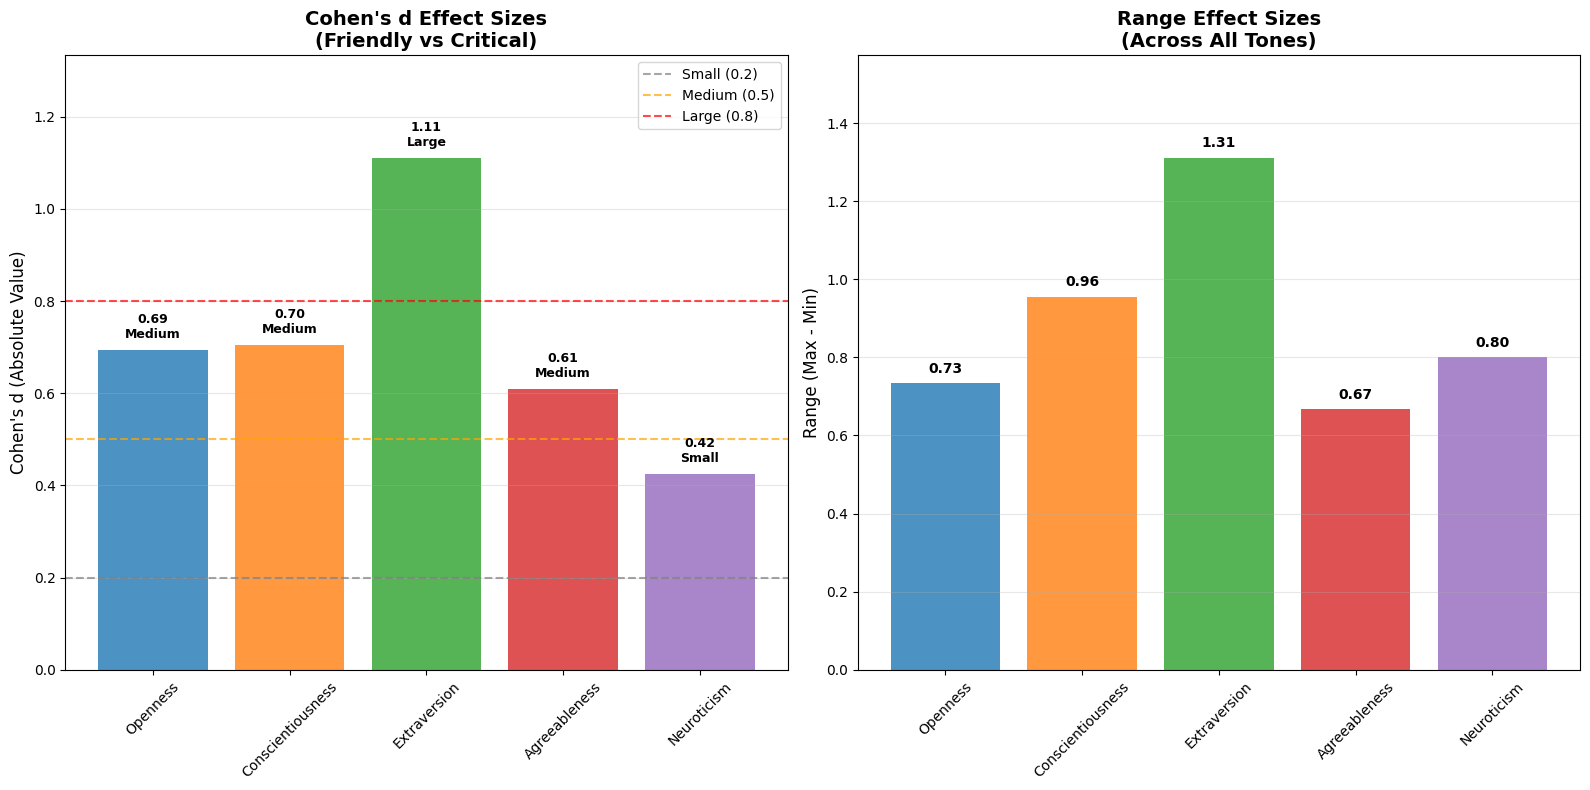

In [5]:
# Create visualization comparing Cohen's d and Range effects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Extract data for visualization
traits_display = [result['trait_display'] for result in friendly_vs_critical]
cohens_d_values = [abs(result['cohens_d']) for result in friendly_vs_critical]  # Use absolute values
range_values = range_effects

# Cohen's d bar chart
bars1 = ax1.bar(traits_display, cohens_d_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], alpha=0.8)
ax1.set_title("Cohen's d Effect Sizes\n(Friendly vs Critical)", fontsize=14, fontweight='bold')
ax1.set_ylabel("Cohen's d (Absolute Value)", fontsize=12)
ax1.set_ylim(0, max(cohens_d_values) * 1.2)

# Add Cohen's d interpretation lines
ax1.axhline(y=0.2, color='gray', linestyle='--', alpha=0.7, label='Small (0.2)')
ax1.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium (0.5)')
ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Large (0.8)')
ax1.legend(fontsize=10)

# Add value labels on bars
for bar, value, interpretation in zip(bars1, cohens_d_values, [result['interpretation'] for result in friendly_vs_critical]):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
             f'{value:.2f}\n{interpretation}', ha='center', va='bottom', 
             fontsize=9, fontweight='bold')

ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Range effect bar chart
bars2 = ax2.bar(traits_display, range_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], alpha=0.8)
ax2.set_title("Range Effect Sizes\n(Across All Tones)", fontsize=14, fontweight='bold')
ax2.set_ylabel("Range (Max - Min)", fontsize=12)
ax2.set_ylim(0, max(range_values) * 1.2)

# Add value labels on bars
for bar, value in zip(bars2, range_values):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
             f'{value:.2f}', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Effect Size Rankings and Interpretation

In [6]:
# Create comprehensive ranking table
effect_size_comparison = []

for i, result in enumerate(friendly_vs_critical):
    effect_size_comparison.append({
        'Trait': result['trait_display'],
        'Cohens_d': abs(result['cohens_d']),
        'Cohen_Interpretation': result['interpretation'],
        'Range_Effect': range_effects[i],
        'Mean_Difference': result['mean_diff']
    })

# Convert to DataFrame for easier analysis
effect_df = pd.DataFrame(effect_size_comparison)

# Sort by Cohen's d
effect_df_sorted = effect_df.sort_values('Cohens_d', ascending=False)

print("=== EFFECT SIZE RANKINGS ===")
print("Ranked by Cohen's d (Friendly vs Critical tone)")
print("-" * 80)
print("Rank  Trait             Cohen's d  Interpretation  Range   Mean Diff")
print("-" * 80)

for rank, (idx, row) in enumerate(effect_df_sorted.iterrows(), 1):
    print(f"{rank:2d}.  {row['Trait']:15} {row['Cohens_d']:8.2f}  {row['Cohen_Interpretation']:12}  {row['Range_Effect']:6.2f}  {row['Mean_Difference']:8.2f}")

print("\n=== KEY INSIGHTS ===")

# Identify traits with large effects
large_effects = effect_df_sorted[effect_df_sorted['Cohens_d'] >= 0.8]
medium_effects = effect_df_sorted[(effect_df_sorted['Cohens_d'] >= 0.5) & (effect_df_sorted['Cohens_d'] < 0.8)]

print(f"\nTraits with LARGE effects (Cohen's d ≥ 0.8):")
for _, row in large_effects.iterrows():
    print(f"  • {row['Trait']}: d = {row['Cohens_d']:.2f}")

print(f"\nTraits with MEDIUM effects (0.5 ≤ Cohen's d < 0.8):")
for _, row in medium_effects.iterrows():
    print(f"  • {row['Trait']}: d = {row['Cohens_d']:.2f}")

# Compare Cohen's d vs Range rankings
print(f"\n=== COHEN'S d vs RANGE COMPARISON ===")
print("Shows whether standardized (Cohen's d) and raw (range) effect sizes agree:")
print("-" * 60)

cohens_ranking = effect_df_sorted['Trait'].tolist()
range_ranking = effect_df.sort_values('Range_Effect', ascending=False)['Trait'].tolist()

for i, trait in enumerate(cohens_ranking):
    range_rank = range_ranking.index(trait) + 1
    cohen_rank = i + 1
    agreement = "✓" if abs(range_rank - cohen_rank) <= 1 else "✗"
    print(f"{trait:15} | Cohen's d rank: {cohen_rank}  | Range rank: {range_rank}  | {agreement}")

=== EFFECT SIZE RANKINGS ===
Ranked by Cohen's d (Friendly vs Critical tone)
--------------------------------------------------------------------------------
Rank  Trait             Cohen's d  Interpretation  Range   Mean Diff
--------------------------------------------------------------------------------
 1.  Extraversion        1.11  Large           1.31      0.73
 2.  Conscientiousness     0.70  Medium          0.96      0.56
 3.  Openness            0.69  Medium          0.73      0.51
 4.  Agreeableness       0.61  Medium          0.67      0.62
 5.  Neuroticism         0.42  Small           0.80     -0.36

=== KEY INSIGHTS ===

Traits with LARGE effects (Cohen's d ≥ 0.8):
  • Extraversion: d = 1.11

Traits with MEDIUM effects (0.5 ≤ Cohen's d < 0.8):
  • Conscientiousness: d = 0.70
  • Openness: d = 0.69
  • Agreeableness: d = 0.61

=== COHEN'S d vs RANGE COMPARISON ===
Shows whether standardized (Cohen's d) and raw (range) effect sizes agree:
-----------------------------------

### Statistical Significance for Tone Effects

In [10]:
print("=== ONE-WAY ANOVA: TONE EFFECTS ON PERSONALITY TRAITS ===\n")

significant_traits = []
tone_effects_summary = []

for trait in personality_traits:
    # Group data by tone for this trait
    friendly = df[df['tone'] == 'friendly'][trait]
    formal = df[df['tone'] == 'formal'][trait]
    passive_agg = df[df['tone'] == 'passive-aggressive'][trait]
    critical = df[df['tone'] == 'critical'][trait]
    
    # Perform one-way ANOVA
    f_statistic, p_value = f_oneway(friendly, formal, passive_agg, critical)
    
    # Calculate effect size (range)
    tone_means = df.groupby('tone')[trait].mean()
    effect_size_range = tone_means.max() - tone_means.min()
    
    # Determine significance
    is_significant = p_value < 0.05
    significance_level = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    print(f"{trait.upper()}:")
    print(f"  F-statistic: {f_statistic:.3f}")
    print(f"  p-value: {p_value:.4f} {significance_level}")
    print(f"  Effect size (range): {effect_size_range:.3f}")
    print(f"  Significant: {'YES' if is_significant else 'NO'}")
    print()
    
    # Store results
    tone_effects_summary.append({
        'trait': trait,
        'f_statistic': f_statistic,
        'p_value': p_value,
        'effect_size': effect_size_range,
        'significant': is_significant
    })
    
    if is_significant:
        significant_traits.append(trait)

# Summary of significant effects
print("=== SUMMARY OF SIGNIFICANT TONE EFFECTS ===")
print(f"Traits with significant tone effects: {significant_traits}")
print(f"Number of significant effects: {len(significant_traits)}/5")

# Create results DataFrame
results_df = pd.DataFrame(tone_effects_summary)
print("\nComplete Results Table:")
print(results_df.round(4))

=== ONE-WAY ANOVA: TONE EFFECTS ON PERSONALITY TRAITS ===

OPENNESS:
  F-statistic: 8.580
  p-value: 0.0000 ***
  Effect size (range): 0.733
  Significant: YES

CONSCIENTIOUSNESS:
  F-statistic: 23.415
  p-value: 0.0000 ***
  Effect size (range): 0.956
  Significant: YES

EXTRAVERSION:
  F-statistic: 23.115
  p-value: 0.0000 ***
  Effect size (range): 1.311
  Significant: YES

AGREEABLENESS:
  F-statistic: 4.939
  p-value: 0.0026 **
  Effect size (range): 0.667
  Significant: YES

NEUROTICISM:
  F-statistic: 9.753
  p-value: 0.0000 ***
  Effect size (range): 0.800
  Significant: YES

=== SUMMARY OF SIGNIFICANT TONE EFFECTS ===
Traits with significant tone effects: ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
Number of significant effects: 5/5

Complete Results Table:
               trait  f_statistic  p_value  effect_size  significant
0           openness       8.5799   0.0000       0.7333         True
1  conscientiousness      23.4147   0.0000     

### Ranking Traits by Effect Strength

In [11]:
# Rank traits by statistical and practical significance
results_df_sorted = results_df.sort_values(['significant', 'effect_size'], ascending=[False, False])

print("\n=== TRAITS RANKED BY TONE SENSITIVITY ===")
print("(Significant effects first, then by effect size)")
print("-" * 60)

for idx, row in results_df_sorted.iterrows():
    status = "SIGNIFICANT" if row['significant'] else "Not Significant"
    print(f"{row['trait'].upper():15} | p={row['p_value']:.4f} | Range={row['effect_size']:.3f} | {status}")

# Select top 3 traits for visualization (significant ones with largest effects)
top_traits = results_df_sorted.head(3)['trait'].tolist()
print(f"\nTop 3 traits for visualization: {top_traits}")


=== TRAITS RANKED BY TONE SENSITIVITY ===
(Significant effects first, then by effect size)
------------------------------------------------------------
EXTRAVERSION    | p=0.0000 | Range=1.311 | SIGNIFICANT
CONSCIENTIOUSNESS | p=0.0000 | Range=0.956 | SIGNIFICANT
NEUROTICISM     | p=0.0000 | Range=0.800 | SIGNIFICANT
OPENNESS        | p=0.0000 | Range=0.733 | SIGNIFICANT
AGREEABLENESS   | p=0.0026 | Range=0.667 | SIGNIFICANT

Top 3 traits for visualization: ['extraversion', 'conscientiousness', 'neuroticism']


### Tone Effects on Personality Traits (Line Chart)

Openness range across tones: 0.73
Conscientiousness range across tones: 0.96
Extraversion range across tones: 1.31
Agreeableness range across tones: 0.67
Neuroticism range across tones: 0.80


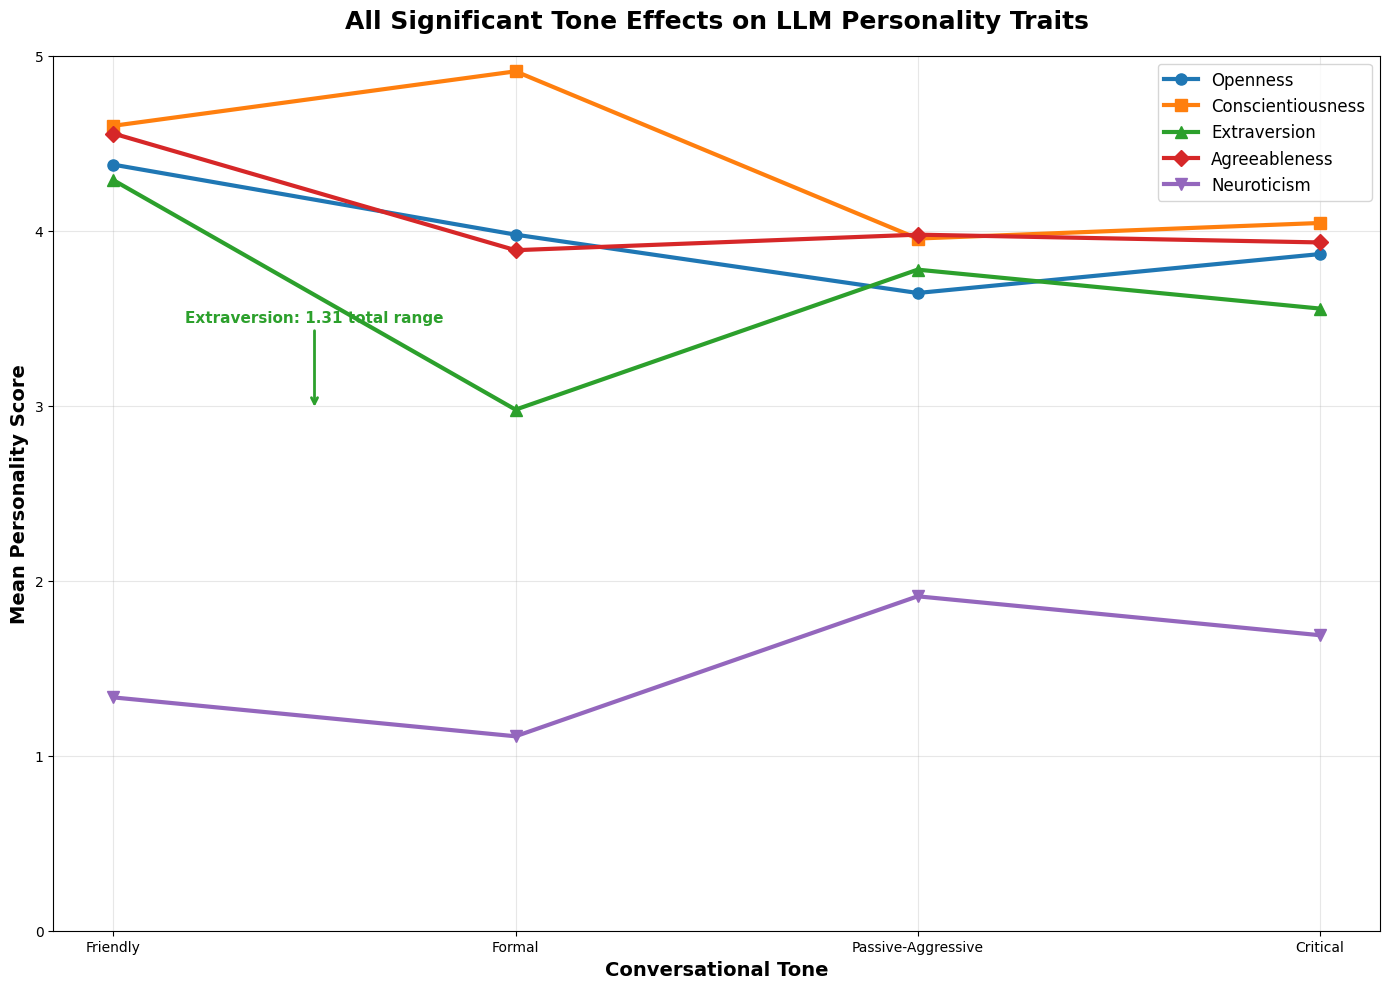


=== TONE EFFECTS SUMMARY (All Significant Traits) ===
Trait                Range    Max Tone      Min Tone
-------------------------------------------------------
Openness          0.73    friendly     (4.38)  passive-aggressive (3.64)
Conscientiousness   0.96    formal       (4.91)  passive-aggressive (3.96)
Extraversion      1.31    friendly     (4.29)  formal       (2.98)
Agreeableness     0.67    friendly     (4.56)  formal       (3.89)
Neuroticism       0.80    passive-aggressive (1.91)  formal       (1.11)

=== DETAILED TONE MEANS TABLE ===
                    Openness  Conscientiousness  Extraversion  Agreeableness  \
Friendly                4.38               4.60          4.29           4.56   
Formal                  3.98               4.91          2.98           3.89   
Passive-Aggressive      3.64               3.96          3.78           3.98   
Critical                3.87               4.04          3.56           3.93   

                    Neuroticism  
Friendly   

In [15]:
# Calculate personality trait means by tone
tone_order = ['friendly', 'formal', 'passive-aggressive', 'critical']
tone_means = df.groupby('tone')[personality_traits].mean().reindex(tone_order)

# Display names for tones and traits
tones_display = ['Friendly', 'Formal', 'Passive-Aggressive', 'Critical']
trait_display_names = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']

# Create line plot with all 5 traits
plt.figure(figsize=(14, 10))

# Define colors and markers for each trait
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', '^', 'D', 'v']
linestyles = ['-', '-', '-', '-', '-']

# Plot each trait
for i, (trait, display_name) in enumerate(zip(personality_traits, trait_display_names)):
    values = tone_means[trait].values
    plt.plot(tones_display, values, 
             marker=markers[i], linewidth=3, markersize=8,
             label=display_name, color=colors[i], linestyle=linestyles[i])
    
    # Calculate and display the range for this trait
    trait_range = values.max() - values.min()
    print(f"{display_name} range across tones: {trait_range:.2f}")

# Customize chart
plt.title('All Significant Tone Effects on LLM Personality Traits', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Conversational Tone', fontsize=14, fontweight='bold')
plt.ylabel('Mean Personality Score', fontsize=14, fontweight='bold')
plt.ylim(0, 5)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=0)

# Add some annotations for the most dramatic changes
# Find trait with largest range
ranges = [tone_means[trait].max() - tone_means[trait].min() for trait in personality_traits]
max_range_idx = np.argmax(ranges)
max_range_trait = personality_traits[max_range_idx]
max_range_display = trait_display_names[max_range_idx]

# Annotate the largest change
max_vals = tone_means[max_range_trait].values
max_change_idx = np.argmax(np.abs(np.diff(max_vals)))
plt.annotate(f'{max_range_display}: {ranges[max_range_idx]:.2f} total range', 
             xy=(max_change_idx + 0.5, max_vals[max_change_idx + 1]), 
             xytext=(max_change_idx + 0.5, max_vals[max_change_idx + 1] + 0.5),
             arrowprops=dict(arrowstyle='->', color=colors[max_range_idx], lw=2),
             fontsize=11, color=colors[max_range_idx], fontweight='bold',
             ha='center')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== TONE EFFECTS SUMMARY (All Significant Traits) ===")
print("Trait                Range    Max Tone      Min Tone")
print("-" * 55)

for i, trait in enumerate(personality_traits):
    values = tone_means[trait]
    trait_range = values.max() - values.min()
    max_tone = tone_order[values.argmax()]
    min_tone = tone_order[values.argmin()]
    max_val = values.max()
    min_val = values.min()
    
    print(f"{trait_display_names[i]:15} {trait_range:6.2f}    {max_tone:12} ({max_val:.2f})  {min_tone:12} ({min_val:.2f})")

# Show the actual data table
print(f"\n=== DETAILED TONE MEANS TABLE ===")
tone_means_display = tone_means.copy()
tone_means_display.columns = trait_display_names
tone_means_display.index = tones_display
print(tone_means_display.round(2))

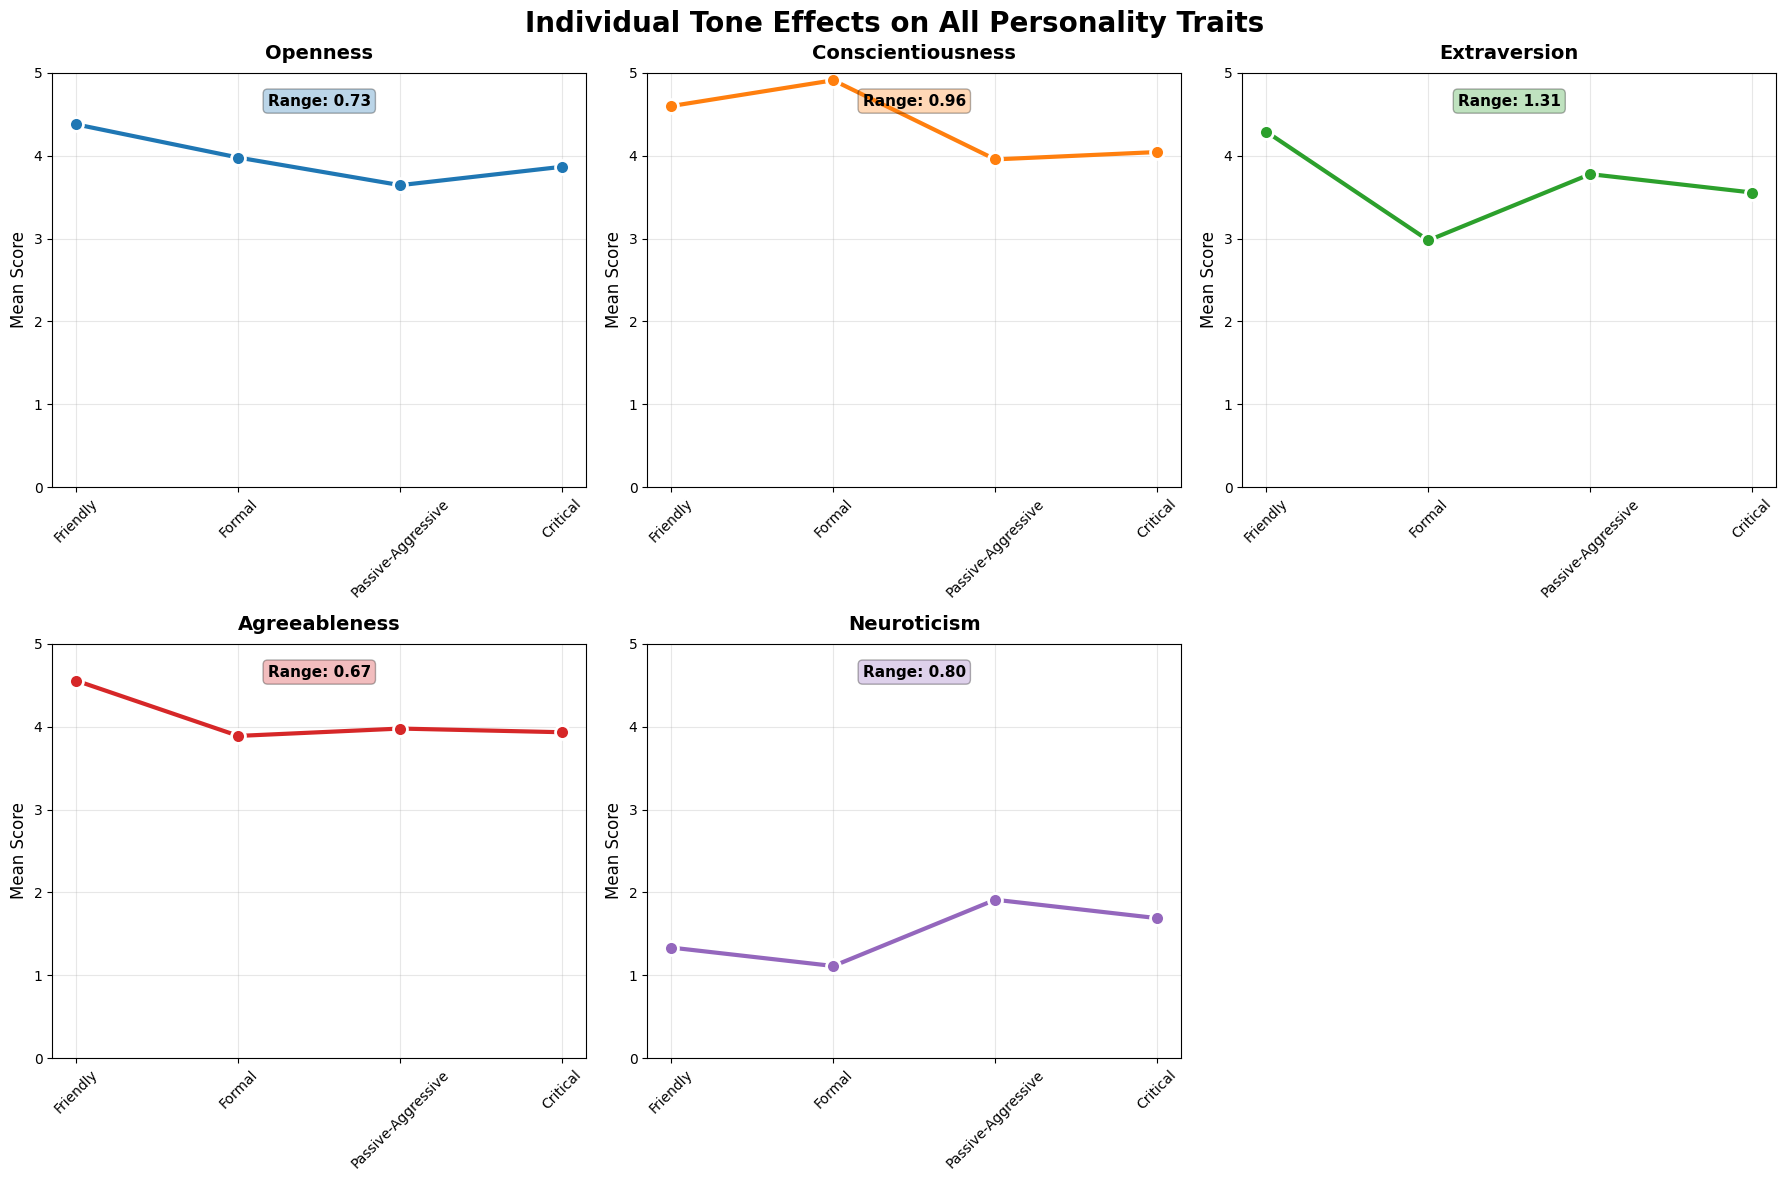

In [16]:
# Alternative: Create subplots for cleaner visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Individual Tone Effects on All Personality Traits', fontsize=20, fontweight='bold')

# Remove the empty 6th subplot
axes[1, 2].remove()

for i, (trait, display_name) in enumerate(zip(personality_traits, trait_display_names)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    values = tone_means[trait].values
    
    # Plot with emphasis on dramatic changes
    ax.plot(tones_display, values, 'o-', linewidth=3, markersize=10,
            color=colors[i], markerfacecolor=colors[i], markeredgecolor='white', 
            markeredgewidth=2)
    
    # Customize individual subplot
    ax.set_title(f'{display_name}', fontsize=14, fontweight='bold', pad=10)
    ax.set_ylabel('Mean Score', fontsize=12)
    ax.set_ylim(0, 5)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add range annotation
    trait_range = values.max() - values.min()
    ax.text(0.5, 0.95, f'Range: {trait_range:.2f}', transform=ax.transAxes,
            fontsize=11, fontweight='bold', ha='center', va='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.3))

plt.tight_layout()
plt.show()

### LLM Tone Sensitivity Comparison (Bar Chart)

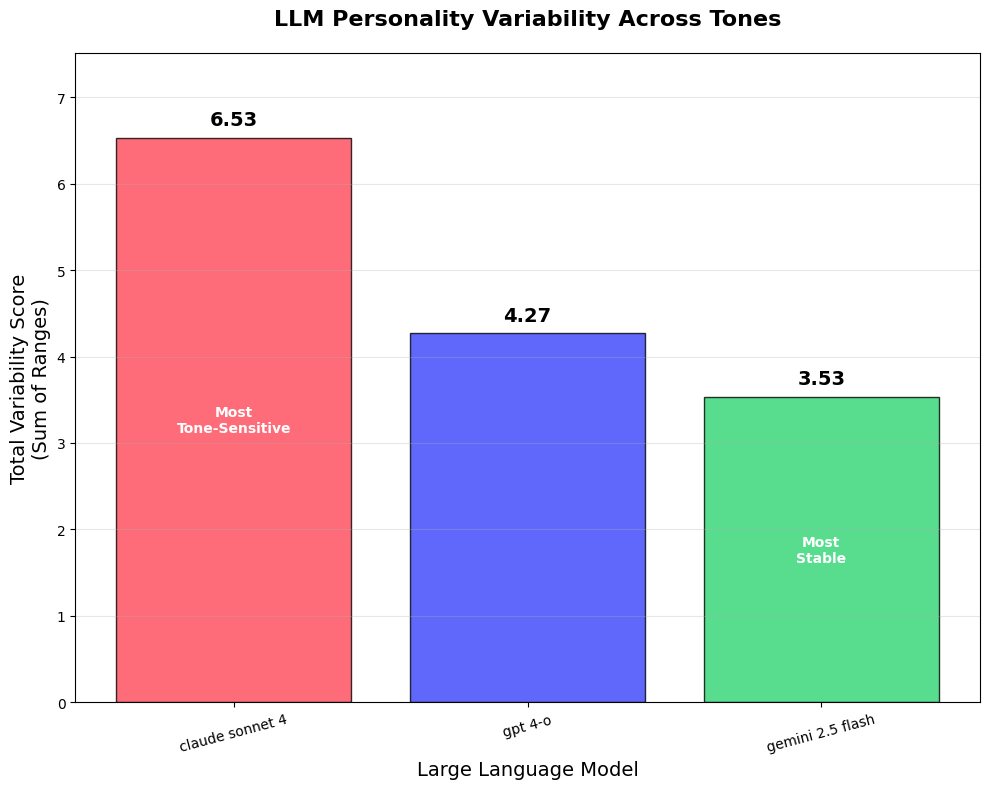

LLM Tone Sensitivity Rankings:
claude sonnet 4: 6.53
gpt 4-o: 4.27
gemini 2.5 flash: 3.53


In [17]:
# Calculate variability scores for each LLM
llm_variability = []

for llm in df['llm'].unique():
    llm_data = df[df['llm'] == llm]
    tone_means = llm_data.groupby('tone')[personality_traits].mean()
    
    # Calculate range for each trait, then sum for total variability
    total_variability = 0
    for trait in personality_traits:
        trait_range = tone_means[trait].max() - tone_means[trait].min()
        total_variability += trait_range
    
    llm_variability.append({
        'LLM': llm,
        'Variability': total_variability
    })

# Convert to DataFrame and sort by variability
variability_df = pd.DataFrame(llm_variability)
variability_df = variability_df.sort_values('Variability', ascending=False)

# Prepare data for plotting
llms = variability_df['LLM'].values
variability_scores = variability_df['Variability'].values
colors = ['#FF4757', '#3742FA', '#2ED573']

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.bar(llms, variability_scores, color=colors, alpha=0.8, 
              edgecolor='black', linewidth=1)

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, variability_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{score:.2f}', ha='center', va='bottom', 
            fontsize=14, fontweight='bold')
    
    # Add interpretation labels
    if i == 0:  # Highest variability
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                'Most\nTone-Sensitive', ha='center', va='center', 
                fontsize=10, color='white', fontweight='bold')
    elif i == len(bars)-1:  # Lowest variability
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                'Most\nStable', ha='center', va='center', 
                fontsize=10, color='white', fontweight='bold')

# Customize chart
ax.set_title('LLM Personality Variability Across Tones', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Total Variability Score\n(Sum of Ranges)', fontsize=14)
ax.set_xlabel('Large Language Model', fontsize=14)
ax.set_ylim(0, max(variability_scores) * 1.15)
ax.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Print the actual variability rankings
print("LLM Tone Sensitivity Rankings:")
for i, row in variability_df.iterrows():
    print(f"{row['LLM']}: {row['Variability']:.2f}")